In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load embeddings
data = np.load("/workspace/embeddings.npz", allow_pickle=True)
embeddings = data['embeddings']
paths = data['paths']
labels = data['labels']
splits = data['splits'] if 'splits' in data else None

print(f"Embeddings shape: {embeddings.shape}")
print(f"Classes: {np.unique(labels)}")

Embeddings shape: (17411, 1024)
Classes: ['test' 'train' 'valid']


In [2]:
# Optional: PCA for faster KNN and noise reduction
pca = PCA(n_components=128)
embeddings_reduced = pca.fit_transform(embeddings)
print(f"Reduced shape: {embeddings_reduced.shape}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Reduced shape: (17411, 128)
Variance explained: 96.42%


In [3]:
# Method 1: K-Distance Outlier Detection
k = 10  # number of neighbors
knn = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
knn.fit(embeddings_reduced)
distances, indices = knn.kneighbors(embeddings_reduced)

# Outlier score = mean distance to k neighbors
outlier_scores = distances.mean(axis=1)

# Find outliers (top 5%)
threshold = np.percentile(outlier_scores, 95)
outlier_mask = outlier_scores > threshold

print(f"Total samples: {len(outlier_scores)}")
print(f"Outliers found: {outlier_mask.sum()}")
print(f"Threshold: {threshold:.4f}")

Total samples: 17411
Outliers found: 871
Threshold: 0.2282


In [8]:
# Get outliers sorted by score (worst first)
sorted_indices = np.argsort(outlier_scores)[::-1]
outlier_indices = sorted_indices[outlier_mask[sorted_indices]]

outlier_paths = paths[outlier_indices]
outlier_labels = labels[outlier_indices]
outlier_scores_sorted = outlier_scores[outlier_indices]

print(f"Top outliers: {len(outlier_paths)}")

Top outliers: 871


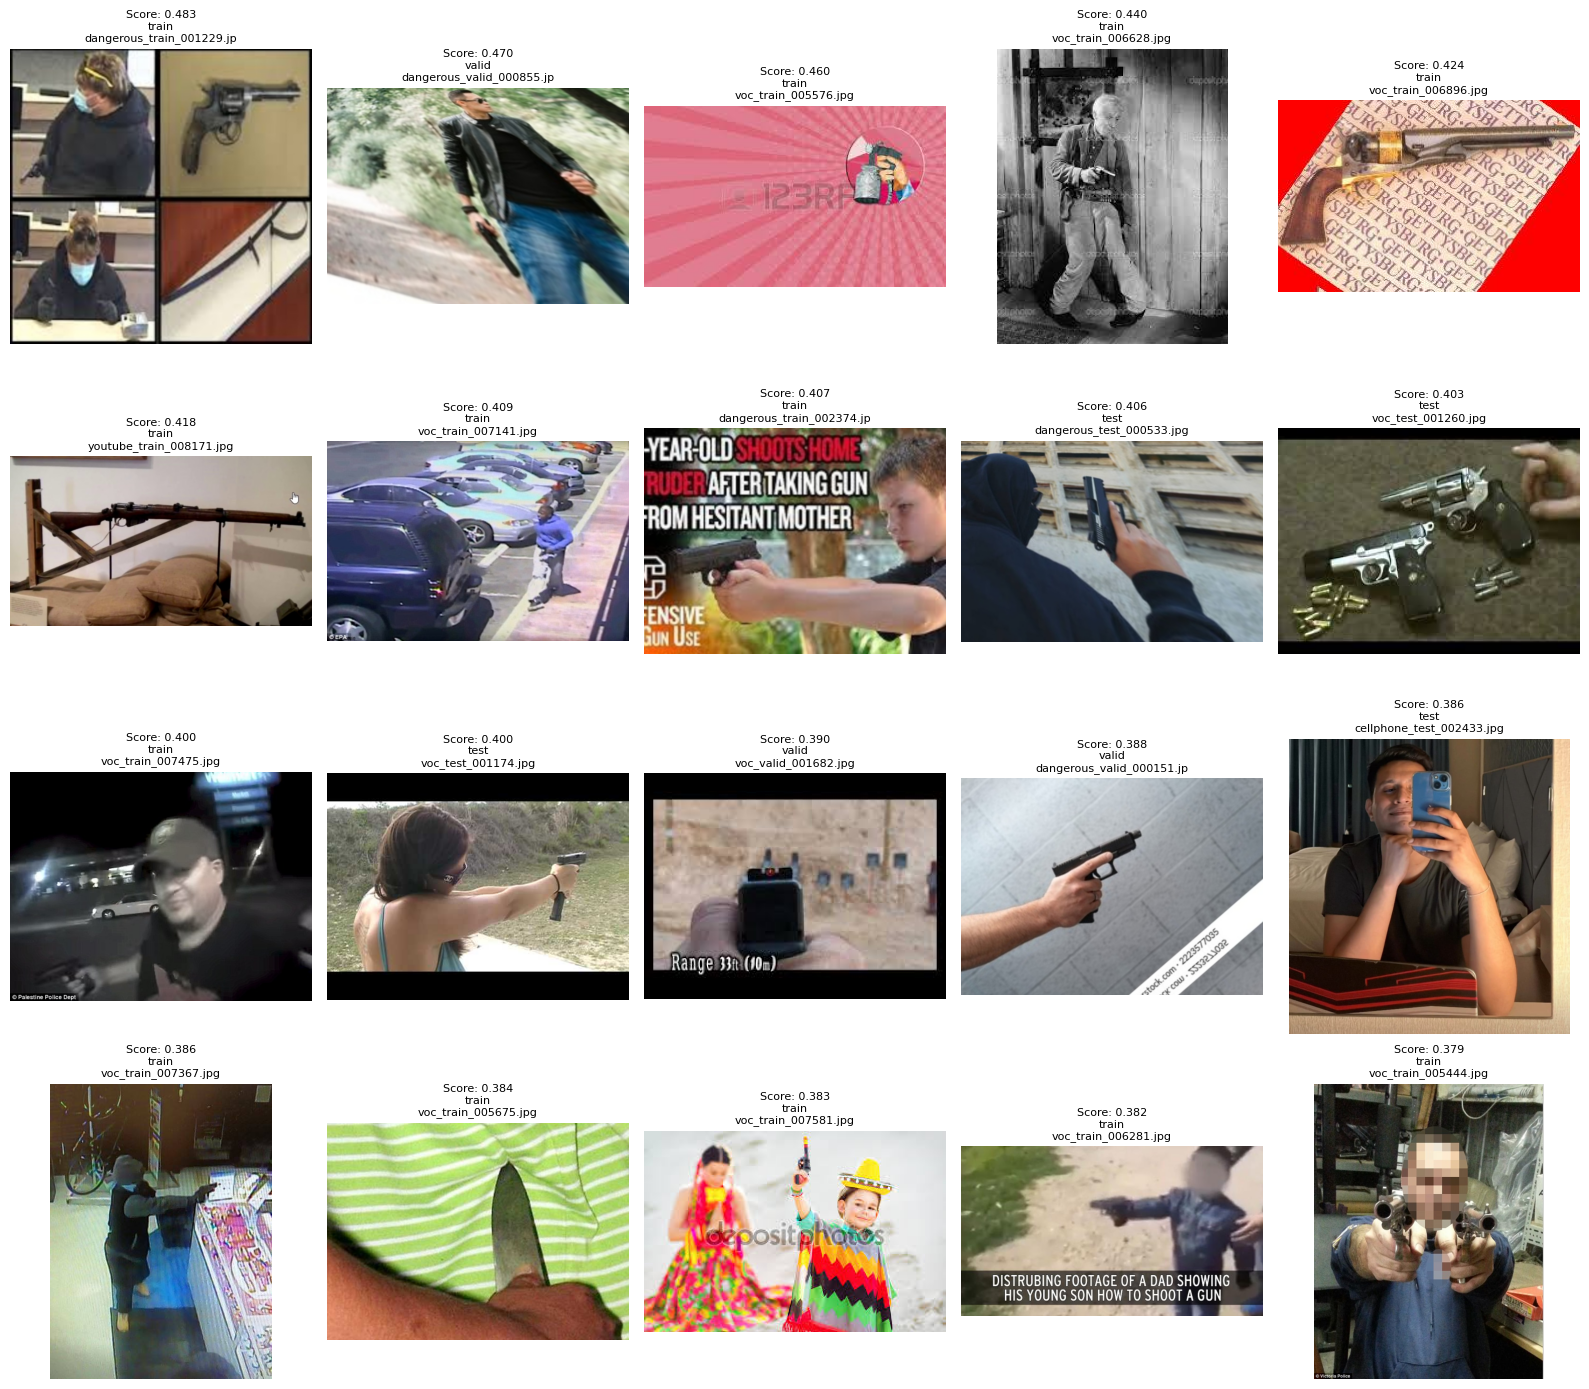

In [9]:
# Visualize top 20 outliers
from PIL import Image
from pathlib import Path

def show_top_outliers(paths, scores, labels, n=20):
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5*rows))
    axes = axes.flatten()
    
    for i in range(min(n, len(paths))):
        try:
            img = Image.open(paths[i])
            axes[i].imshow(img)
            fname = Path(paths[i]).name
            axes[i].set_title(f"Score: {scores[i]:.3f}\n{labels[i]}\n{fname[:25]}", fontsize=8)
        except Exception as e:
            axes[i].set_title(f"Error: {e}", fontsize=8)
        axes[i].axis('off')
    
    for i in range(min(n, len(paths)), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_top_outliers(outlier_paths, outlier_scores_sorted, outlier_labels, n=20)

In [11]:
# Save outliers flat (no folder structure)
import shutil

SAVE_DIR = Path("/workspace/outliers")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

saved_count = 0
for path, label, score in zip(outlier_paths, outlier_labels, outlier_scores_sorted):
    path = Path(path)
    
    score_prefix = f"{score:.4f}".replace('.', '_')
    save_path = SAVE_DIR / f"{score_prefix}_{label}_{path.name}"
    
    try:
        shutil.copy(path, save_path)
        saved_count += 1
    except Exception as e:
        print(f"Error copying {path}: {e}")

print(f"Saved {saved_count} outlier images to {SAVE_DIR}")

Saved 871 outlier images to /workspace/outliers
